In [1]:
#Boiler Plate

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#select one of the devices, note GPU (Nvidia or Metal) slower than CPU atm

#cpu
device = torch.device("cpu")

#nvidia cuda
#device = torch.device("cuda")

#high-performance training on Metal GPU for Mac - https://pytorch.org/docs/stable/notes/mps.html
#device = torch.device("mps")
#%env PYTORCH_ENABLE_MPS_FALLBACK=0

#words(names) loaded
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [2]:
#parameters of NN

vocab_size = len(itos) #vocabulary size - all letter and start/end character (.)

block_size = 3 #context length: how many characters do we take to predict the next one
n_embd = 10 #dimensionalityof the character embedding vectors
n_hidden = 200 #number of neurons in the hidden layer of the MLP

max_steps = 200000 #no steps for training
batch_size = 32 #minibatch size

In [3]:
#build dataset
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10%, 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor(0.0046) tensor(0.9908)
tensor(-0.0008) tensor(0.9821)


(array([4.79018347e-05, 7.18527521e-05, 9.58036694e-05, 2.39509174e-05,
        7.18527521e-05, 2.63460091e-04, 2.63460091e-04, 7.90380273e-04,
        1.29334954e-03, 1.84422064e-03, 3.40103026e-03, 5.02969265e-03,
        7.35293163e-03, 1.35562192e-02, 2.03822307e-02, 3.09206343e-02,
        4.51953811e-02, 6.55057590e-02, 9.41031543e-02, 1.32089309e-01,
        1.78841500e-01, 2.32204144e-01, 2.94165167e-01, 3.46282363e-01,
        3.98040296e-01, 4.29463899e-01, 4.32433813e-01, 4.14350870e-01,
        3.71502679e-01, 3.22714660e-01, 2.57184951e-01, 1.99822504e-01,
        1.47753209e-01, 1.09359889e-01, 7.79602360e-02, 5.35303003e-02,
        3.55671123e-02, 2.51005614e-02, 1.50411761e-02, 1.04905018e-02,
        6.44279677e-03, 3.49683393e-03, 2.73040458e-03, 1.34125137e-03,
        1.05384036e-03, 4.55067430e-04, 2.15558256e-04, 1.43705504e-04,
        9.58036694e-05, 9.58036694e-05]),
 array([-5.4732399 , -5.26447963, -5.05571936, -4.84695909, -4.63819881,
        -4.42943854, 

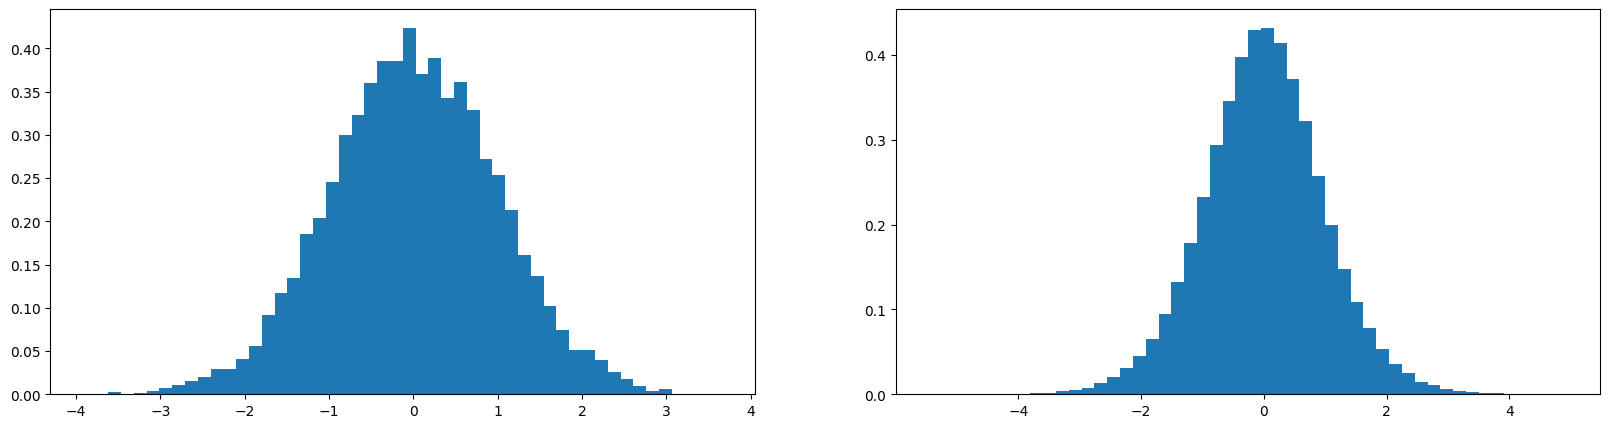

In [4]:
#start from minute mark 28:20
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 #modify to keep std of y under control (under 1 like in x) 
y= x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [5]:
#so for tanh, w mod should be as follows as advised in https://pytorch.org/docs/stable/nn.init.html as per listed reference "Delving deep into rectifiers..." by He et.al.2015
(5 /3) / ( (n_embd * block_size) ** 0.5)

0.3042903097250923

In [6]:
g = torch.Generator().manual_seed(2147483647) #deterministic reproducibility
C = torch.randn((vocab_size,n_embd),                generator=g).to(device) 

# fix tanh layer too saturated at init by manual factoring
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g).to(device) * (5 /3) / ( (n_embd * block_size) ** 0.5) #above listed better way to combat -1 and 1 concentration
#b1 = torch.randn(n_hidden,                          generator=g).to(device) * 0.01 #not needed due to BatchNorm

# fix softmax confidently wrong by manual factoring
W2 = torch.randn((n_hidden, vocab_size),            generator=g).to(device) * 0.01 #to combat initial high loss, which should be -log(1/27)=3.2958.
b2 = torch.randn(vocab_size,                        generator=g).to(device) * 0 #to combat initial high loss

#gain and bias for batch normalization as per BatchNorm paper: https://arxiv.org/abs/1502.03167 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
        p.requires_grad = True


12097


In [7]:
lossi = []

pp = 0
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters in vectors
    embcat = emb.view(emb.shape[0], -1) #concatanate the vectors
    #linear layer
    hpreact = embcat @ W1# + b1 #hidden layer pre-activation, b1 unnecassry due to batching: it is added here and substracted 3 lines later
    #batch normalization at initialization as per BatchNorm paper: https://arxiv.org/abs/1502.03167
    bnmeani = hpreact.mean(0 , keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ( hpreact - bnmeani ) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Ytr[ix]) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #print progress
    currentStep = i + 1
    totalNoSteps = max_steps
    currentProgress = int(float(currentStep) / float(totalNoSteps) *100)
    reportingStep = 2
    if (currentStep > pp) and (currentProgress % reportingStep == 0):
        progress = "Progressed " + str(currentProgress) + "%" + " at Step " + str(currentStep) + " of " + str(totalNoSteps) + " with loss " + f'{loss.item():.4f}'
        print(progress, end="\r")
        pp = currentStep + (totalNoSteps / 100) - reportingStep #cut-off until next step

    #track stats
    lossi.append(loss.log10().item())

    #break #to see initial loss

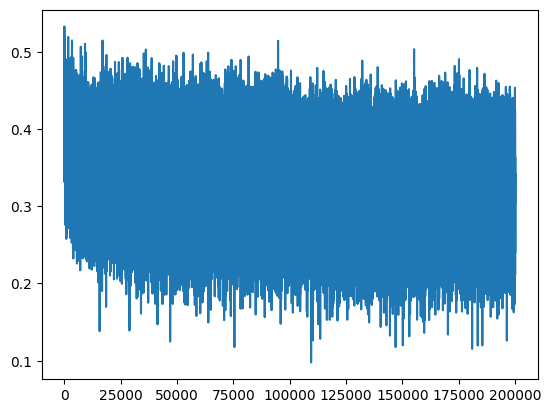

In [8]:
plt.plot(lossi) #no more hockey stick due to high initial loss

In [9]:
# calibrate the batch norm statistics at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [10]:
bnstd

tensor([[2.3180, 1.9779, 1.9661, 2.1366, 2.3308, 2.4496, 2.1545, 2.2389, 2.2520,
         2.0473, 2.4434, 2.2636, 2.0590, 2.1966, 1.9379, 2.7376, 2.4003, 1.8734,
         2.1654, 2.2979, 2.1763, 2.4675, 2.0542, 2.1448, 2.0734, 1.9834, 2.1899,
         2.6569, 2.4516, 2.3357, 1.6746, 1.8719, 2.0306, 1.9018, 2.1751, 2.0201,
         2.6048, 2.0686, 1.7246, 1.8847, 2.1271, 2.0575, 2.4424, 1.9899, 2.1021,
         2.4055, 2.1443, 2.6659, 2.2895, 2.5410, 2.1197, 1.8970, 1.7952, 1.7494,
         2.4012, 2.2687, 1.8617, 2.2695, 2.4958, 1.7832, 2.2730, 2.1360, 2.0930,
         2.3763, 2.1851, 2.1275, 2.1396, 2.4145, 1.9595, 2.2082, 2.2145, 1.9846,
         1.9964, 2.3310, 1.9104, 1.7241, 2.6101, 2.1843, 1.7922, 2.4059, 2.2133,
         1.7586, 2.0061, 2.2215, 2.4505, 2.2982, 2.1866, 2.3506, 2.2673, 2.4957,
         2.0521, 2.0158, 2.1269, 1.9221, 1.9355, 2.4288, 2.1265, 1.9726, 1.9275,
         2.2309, 2.1202, 1.9348, 2.3101, 2.1515, 1.9881, 2.2147, 2.0686, 2.1845,
         1.8946, 2.1217, 2.5

In [11]:
bnstd_running

tensor([[2.2928, 1.9427, 1.9364, 2.0953, 2.2995, 2.4166, 2.1407, 2.2075, 2.2234,
         2.0265, 2.4173, 2.2320, 2.0377, 2.1739, 1.9096, 2.7113, 2.3809, 1.8600,
         2.1484, 2.2797, 2.1495, 2.4298, 2.0392, 2.1228, 2.0473, 1.9589, 2.1623,
         2.6292, 2.4343, 2.3131, 1.6525, 1.8554, 2.0204, 1.8838, 2.1689, 1.9952,
         2.6060, 2.0437, 1.7075, 1.8660, 2.0990, 2.0294, 2.4064, 1.9573, 2.0846,
         2.3917, 2.1113, 2.6155, 2.2781, 2.5159, 2.0995, 1.8716, 1.7738, 1.7283,
         2.3768, 2.2484, 1.8444, 2.2612, 2.4763, 1.7612, 2.2516, 2.1111, 2.0801,
         2.3640, 2.1600, 2.1135, 2.1172, 2.3802, 1.9236, 2.1764, 2.1883, 1.9734,
         1.9851, 2.3053, 1.8851, 1.7038, 2.5969, 2.1507, 1.7744, 2.3817, 2.1905,
         1.7303, 1.9745, 2.1958, 2.4254, 2.2609, 2.1657, 2.3311, 2.2450, 2.4851,
         2.0233, 1.9877, 2.1218, 1.9063, 1.9406, 2.4071, 2.1017, 1.9552, 1.8929,
         2.2080, 2.1181, 1.9114, 2.2727, 2.1310, 1.9626, 2.1952, 2.0506, 2.1475,
         1.8702, 2.0897, 2.4

In [12]:
@torch.no_grad() #this decorator disables gradient tracking for below function - efficiency since no backward pass
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1# + b1
    #hpreact = bngain * ( hpreact - hpreact.mean(0 , keepdim=True) ) / hpreact.std(0, keepdim=True) + bnbias #before batch norm calibration
    hpreact = bngain * ( hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)  
    logits = h @ W2 + b2 # (N. vocab_size)
    loss = F.cross_entropy(logits, y) #loss function
    #print(split, loss.item())
    return loss

lossT = split_loss('train')
lossD = split_loss('val')
lossAll = "Losses @ Training & Validation Sets: " + f'{lossT.item():.4f}' + " & " +  f'{lossD.item():.4f}'
print(lossAll)

Losses @ Training & Validation Sets: 2.0674 & 2.1057


In [13]:
#sampling

#sample 10 time for maximum quality
bestquality = 0.0
bestgenwords = ""
bestcountexct = 0

for rand in range(11):
    g = torch.Generator().manual_seed(2147483647+rand)

    generation = []
    numberofgen = 20
    for i in range(numberofgen):

        out = []
        context = [0] * block_size #start with dot
        while True:
            emb = C[torch.tensor([context])] # (1, block_size, d)
            embcat = emb.view(1, -1)
            hpreact = embcat @ W1# + b1
            hpreact = bngain * ( hpreact - bnmean_running) / bnstd_running + bnbias #a.k. did not go on sampling from a batchnorm, so this is my guess
            h = torch.tanh(hpreact) 
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        generated = ''.join(itos[i] for i in out).rstrip(".")
        generation.append(generated) 

    #find the words which already existed in the training set
    genwords = ""
    countexct = 0
    #c = [0 for x in range(0, len(generation))] #just marking the index
    for i, x in enumerate(generation):
        if len(genwords) > 0:
            genwords += ", "

        genwords += x

        if x in words[:n1]:
            #c[i] = 1
            countexct += 1
            genwords += "+"

    quality = (100*(1.0 - float(countexct)/float(numberofgen)))

    if quality > bestquality:
        bestgenwords = genwords
        bestcountexct = countexct
        bestquality = quality

bestcount = str(bestcountexct) + " no. (+ marked) generated words are exact copies from the training set; uniqueness score " + str(numberofgen-bestcountexct) + "/" + str(numberofgen) + ", " + f'{bestquality:.0f}' + "%."

#Markdown output
from IPython.display import display, Markdown, Latex
output = """\
Below setup with `{parameters}`no. parameters, results in Losses of ~`{lossT}` for training / ~`{lossD}` for dev/validation data sets:

`block_size = {block_size} | n_embd = {n_embd} | n_hidden = {n_hidden} | batch_size = {batch_size} | max_steps = {max_steps}`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~{bestquality}%** and other stats as follows:

| First Run|
|---|
| {bestgen1} |
| {bestcount1} |
| {loss1} |
<hr/>
""".format(
    parameters=sum(p.nelement() for p in parameters),
    lossT=f'{lossT:.4f}',
    lossD=f'{lossD:.4f}',
    block_size = block_size,
    n_embd = n_embd,
    n_hidden = n_hidden,
    batch_size = batch_size,
    max_steps = max_steps, 
    bestquality = f'{bestquality:.0f}',
    bestgen1 = bestgenwords,
    bestcount1 = bestcount,
    loss1 = lossAll,
)
display(Markdown(output))


Below setup with `12097`no. parameters, results in Losses of ~`2.0674` for training / ~`2.1057` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| jazque, tahannevan, shaseylynn, kanielladi, doneia, berleiveikarlonie, nehrenufayla, katian, alayja+, alinn, bleigh, fgraeleohawn, ashima, ellona, kaiselylon, eslyn, adda, kreelaiyah, avuya, astbel |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0674 & 2.1057 |
<hr/>


In [14]:
print(output)

Below setup with `12097`no. parameters, results in Losses of ~`2.0674` for training / ~`2.1057` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| jazque, tahannevan, shaseylynn, kanielladi, doneia, berleiveikarlonie, nehrenufayla, katian, alayja+, alinn, bleigh, fgraeleohawn, ashima, ellona, kaiselylon, eslyn, adda, kreelaiyah, avuya, astbel |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0

## Output after batch normalisation

Below setup with `12097`no. parameters, results in Losses of ~`2.0674` for training / ~`2.1057` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| jazque, tahannevan, shaseylynn, kanielladi, doneia, berleiveikarlonie, nehrenufayla, katian, alayja+, alinn, bleigh, fgraeleohawn, ashima, ellona, kaiselylon, eslyn, adda, kreelaiyah, avuya, astbel |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0674 & 2.1057 |
<hr/>

## Output from pre-batch normalisation but with optimised weights

Below setup with `11897`no. parameters, results in Losses of ~`2.0377` for training / ~`2.1070` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| trevne, ory, kens, asie, yasia, zahmer, luzihira, mechesataraviel, krison, dani+, sate, raell, ceranz, makermit, dezicko, mubelle, praplionna, ari, grachmira, dar |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0377 & 2.1070 |
<hr/>


## Output from AI9 notebook

Below setup with `11897`no. parameters, results in Losses of ~`2.0356` for training / ~`2.1027` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| dex, mariah, makilah, tyhammonie, traine, kayk, kata, kreez, pebutharminton, moriella, kinzleed, akareedensedey, niavion, rosbur, hunaven, tahiro, kaspe, breen, hayah, isa+ |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0356 & 2.1027 |
<hr/>